# Import Packages

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import riskfolio as rf
from decision_transformer.models.decision_transformer import DecisionTransformer
from decision_transformer.sum_to_one import project_portfolio_weights
import torch
import pickle

/root/miniconda3/envs/decision-transformer-gym/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Processing

Three CSV files containing YTD historical stock prices for Apple (`AAPL`), Microsoft (`MSFT`), and Tesla (`TSLA`). (From www.nasdaq.com)

For each stock ticker and its corresponding CSV file path:
   - Load the CSV into a pandas DataFrame.
   - Rename the closing price column from `"Close/Last"` to the ticker symbol (e.g., `"AAPL"`).
   - Convert the `"Date"` column to a datetime format.
   - Remove currency symbols (`$`) and commas from the price data, then convert prices to numeric (`float`) values.
   - Keep only the `"Date"` and the renamed ticker column.
   - Sort the DataFrame by date (ascending order).
   - Set `"Date"` as the index for easier merging later.
   - Store each cleaned DataFrame in a dictionary (`price_data`) keyed by ticker.

Then combine All Stocks into a Single DataFrame
   - Combine the individual DataFrames into one single DataFrame (`combined_prices`) by aligning data on dates.
   - Remove rows with missing values to ensure consistency (dates where data is incomplete for any stock).

Save the Combined DataFrame to a CSV File
   - Export the resulting combined dataset (`combined_prices`) as `"data/combined_prices.csv"` for later use or analysis.
   - Print a confirmation message upon completion.

In [32]:
# === Step 1: Define downloaded CSVs ===
# Make sure these paths point to your local copies of the files.
files = {
    "AAPL": "data/AAPL.csv",
    "MSFT": "data/MSFT.csv",
    "TSLA": "data/TSLA.csv"
}

price_data = {}

# === Step 2: Load and clean each file ===
for ticker, path in files.items():
    df = pd.read_csv(path)
    df = df.rename(columns={"Close/Last": ticker})
    df["Date"] = pd.to_datetime(df["Date"])
    df[ticker] = df[ticker].astype(str).str.replace("$", "").str.replace(",", "").astype(float)
    df = df[["Date", ticker]]
    df = df.sort_values("Date")  # ascending order
    df = df.set_index("Date")
    price_data[ticker] = df

# === Step 3: Combine into a single DataFrame ===
combined_prices = pd.concat(price_data.values(), axis=1)
combined_prices = combined_prices.dropna()  # drop rows with missing prices

# === Step 4: Save to CSV ===
combined_prices.to_csv("data/combined_prices.csv")
print("Combined price file saved as 'combined_prices.csv'")

# === Preview ===
print(combined_prices.head())


Combined price file saved as 'combined_prices.csv'
              AAPL    MSFT    TSLA
Date                              
2025-01-02  243.85  418.58  379.28
2025-01-03  243.36  423.35  410.44
2025-01-06  245.00  427.85  411.05
2025-01-07  242.21  422.37  394.36
2025-01-08  242.70  424.56  394.94


# Baseline Method : Mean-Variance Portfolio Optimization (Sharpe Ratio Maximization)

This code implements a classical **mean-variance (MV)** optimization strategy using the `riskfolio-lib` package as a baseline to compare against a **Decision Transformer (DT)** in a portfolio optimization setting.

## Strategy Description

At each day `t` during the last 30 evaluation days, the code performs the following:

1. **Rolling Window Estimation**:
   - Extracts the past 60 days of returns up to time `t` (`train_returns = returns_df.iloc[t - window:t]`).
   - These returns are used to estimate the expected return vector **μ** and the covariance matrix **Σ** of the assets.

2. **Mean-Variance Optimization**:
   - The `Portfolio` object from `riskfolio-lib` is initialized with historical returns.
   - Portfolio statistics are computed using:
     - `method_mu='hist'`: Sample historical average returns.
     - `method_cov='hist'`: Sample historical covariance matrix.
   - The optimizer solves for portfolio weights that **maximize the Sharpe Ratio** using:
     - `model='Classic'`: Classic mean-variance optimization.
     - `rm='MV'`: Mean-Variance risk measure (minimize variance).
     - `obj='Sharpe'`: Objective is to **maximize Sharpe ratio**, i.e.,
       \[
       $\max_w \frac{w^\top \mu}{\sqrt{w^\top \Sigma w}} \quad \text{subject to} \quad \sum_i w_i = 1$
       \]
     - `rf=0`: Risk-free rate is set to zero.
     - `l=0`: No L2 regularization (Ridge penalty).

3. **Portfolio Evaluation**:
   - If optimization fails (e.g., due to numerical issues), it falls back to an **equal-weighted** portfolio.
   - The resulting weights `w` are applied to the next day’s return `test_return` to compute portfolio return:
     \[
     $r^{\text{portfolio}}_t = w^\top r_t$
     \]

4. **Repeat and Record**:
   - This process is repeated over the last 30 days to generate a rolling **out-of-sample evaluation**.
   - The cumulative return is plotted, and summary statistics (mean, standard deviation) of daily returns are printed.

---

## What This Baseline Represents

This method is a **dynamic strategy** that recalibrates the optimal portfolio every day using a **60-day rolling window**. It reflects a **traditional financial model-based approach** relying on:

- Historical data (assumes returns are i.i.d.)
- Analytical solution to portfolio optimization (no learning)
- Assumptions of Gaussian returns, stability of parameters

This serves as a **strong analytical benchmark** to compare with **Decision Transformer**, which:

- Learns from trajectories of past data and decisions
- Does not require explicit modeling of returns or covariances
- Can potentially learn complex dynamics and adapt to non-stationarity

---

## Output Summary

- `Mean daily return`: Average portfolio return across the 30 evaluation days
- `Std dev of daily return`: Measures volatility of the portfolio
- `Cumulative return plot`: Visual performance of portfolio growth over time

This allows for direct comparison with a learned model like Decision Transformer in terms of **return, volatility, and trajectory behavior**.


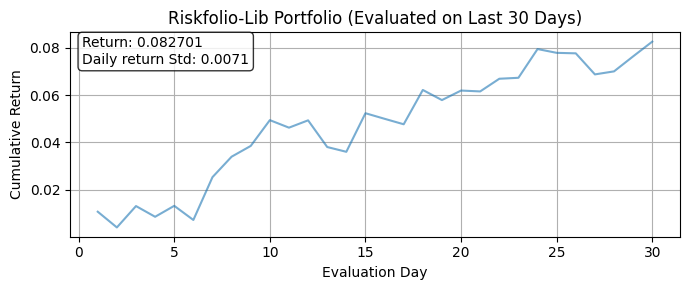

Evaluated on last 31 days using 60-day rolling window.

Sharpe Ratio (daily, risk-free=0): 0.3665


In [97]:
# --- Load price data ---
prices = pd.read_csv("data/combined_prices.csv", index_col=0, parse_dates=True)
returns_df = prices.pct_change().dropna()

# --- Setup ---
window = 60  # use 60-day lookback window
n_eval_days = 31
n_assets = returns_df.shape[1]

# --- Restrict to the last 30 days for evaluation ---
eval_start = len(returns_df) - n_eval_days
portfolio_returns = []
weights_list = []

for t in range(eval_start, len(returns_df)):
    train_returns = returns_df.iloc[t - window:t]
    test_return = returns_df.iloc[t]

    # Estimate and optimize portfolio
    port = rf.Portfolio(returns=train_returns)
    port.assets_stats(method_mu='hist', method_cov='hist')

    weights = port.optimization(
        model='Classic',
        rm='MV',
        obj='Sharpe',
        rf=0,
        l=0,
        hist=True
    )

    if weights is None:
        w = np.ones(n_assets) / n_assets  # fallback to equal weights
    else:
        w = weights.values.flatten()

    weights_list.append(w)
    
    if t == eval_start:
        portfolio_returns.append(0.0)  # initial return is assumed to be 0 like in DT
    else:
        portfolio_returns.append(np.dot(w, test_return.values))

# print(weights_list)
# --- Plot Results ---
portfolio_returns = np.array(portfolio_returns)
cumulative_return_risk = np.cumprod(1 + portfolio_returns) - 1

plt.figure(figsize=(7, 3))
plt.plot(range(1, len(cumulative_return_risk)), cumulative_return_risk[1:], alpha=0.6)
plt.text(0.02, 0.98, f'Return: {np.prod(1 + portfolio_returns) - 1:.6f}\nDaily return Std: {portfolio_returns.std():.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.xlabel("Evaluation Day")
plt.ylabel("Cumulative Return")
plt.title("Riskfolio-Lib Portfolio (Evaluated on Last 30 Days)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Summary ---
print(f"Evaluated on last {n_eval_days} days using {window}-day rolling window.")

if len(portfolio_returns) > 1:
    daily_mean_return = np.mean(portfolio_returns)
    daily_std_return = np.std(portfolio_returns)
    sharpe_ratio = daily_mean_return / daily_std_return
    print(f"\nSharpe Ratio (daily, risk-free=0): {sharpe_ratio:.4f}")
else:
    print("Not enough data points to compute Sharpe Ratio.")


# Mean-Variance Portforlio

Here we are using the same setup as the previous experiment with the simulated data from a multi-variate Gaussian distribution. 

We estimate the mean return and the covariance matrix from the historical stock data from the initial date of the dataset up to the day preceding the final 31 days, then apply the closed-form solution for the last 31 days as evaluation.

Estimated optimal Portfolio Weights: [-0.99818877  2.09039021 -0.09220144]


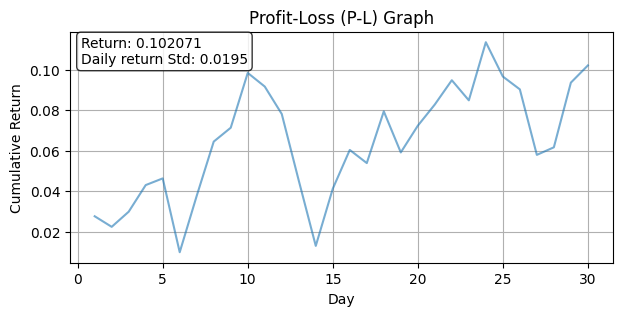


Sharpe Ratio (daily, risk-free=0): 0.1761


In [98]:
def mean_variance_portfolio(mu, Sigma, lambda_):
    """
    Calculate the optimal portfolio weights for a mean-variance portfolio optimization problem
    with multivariate Gaussian returns and a constraint that the portfolio weights sum to 1.
    
    Parameters
    ----------
    mu : array_like, shape (N,)
        Mean return vector (N assets).
    Sigma : array_like, shape (N, N)
        Covariance matrix of returns (N assets).
    lambda_ : float
        Risk aversion coefficient.
    
    Returns
    -------
    a_star : ndarray, shape (N,)
        Optimal portfolio weights for each asset.
    """
    # Calculate the optimal portfolio weights with the constraint that weights sum to 1
    ones = np.ones(len(mu))
    
    # Calculate gamma to ensure the sum of weights equals 1
    gamma = (1 - (1 / lambda_) * np.dot(ones, np.linalg.inv(Sigma).dot(mu))) / np.dot(ones, np.linalg.inv(Sigma).dot(ones))
    
    # Calculate the optimal weights
    a_star = (1 / lambda_) * np.linalg.inv(Sigma).dot(mu) + gamma * np.linalg.inv(Sigma).dot(ones)
    
    return a_star

mu_hat = np.array(returns_df.iloc[0: len(returns_df) - 31].mean())
Sigma_hat = np.cov(returns_df.iloc[0: len(returns_df) - 31], rowvar=False)
lambda_ = 5.0 # Risk aversion parameter “mid‐range”
optimal_weights_hat = mean_variance_portfolio(mu_hat, Sigma_hat, lambda_)
print("Estimated optimal Portfolio Weights:", optimal_weights_hat)

all_returns = np.array(returns_df.iloc[len(returns_df) - 30:])

# Code to plot the portfolio returns and report the mean performance

perf = np.zeros(1)

plt.figure(figsize=(7, 3))
    
# Calculate the portfolio returns for each day
portfolio_returns = np.dot(all_returns, optimal_weights_hat)
    
# Log the portfolio returns
perf[0] = np.prod(1 + portfolio_returns) - 1
    
# Calculate the cumulative return over the 30 days
cumulative_returns_mvp = np.cumprod(1 + portfolio_returns) - 1
    
plt.plot(range(1, len(cumulative_returns_mvp) + 1), cumulative_returns_mvp, alpha=0.6)

plt.text(0.02, 0.98, f'Return: {perf[0]:.6f}\nDaily return Std: {portfolio_returns.std():.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title("Profit-Loss (P-L) Graph")
plt.xlabel("Day")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

if len(portfolio_returns) > 1:
    daily_mean_return = np.mean(portfolio_returns)
    daily_std_return = np.std(portfolio_returns)
    sharpe_ratio = daily_mean_return / daily_std_return
    print(f"\nSharpe Ratio (daily, risk-free=0): {sharpe_ratio:.4f}")
else:
    print("Not enough data points to compute Sharpe Ratio.")

# Decision Transformer

In this experiment, a Decision Transformer (DT) model was trained and evaluated on empirical stock market data. The primary goal was to assess the performance of the DT in the context of portfolio management with realistic stock price trajectories.

The training dataset was constructed by sampling historical stock data from the initial date of the dataset up to the day preceding the final 31 days. This ensured a clear temporal separation between the training and evaluation datasets. The evaluation dataset consisted of the most recent 31 days of stock data available, representing realistic, unseen market conditions for assessing model generalization.

The experiment was conducted using the following command-line configuration:

```bash
python experiment.py --dataset_path data/medium.pkl --eval_dataset_path data/real_stock_eval_31x50.pkl --model_type dt --max_iters 20 --num_steps_per_iter 2000 --batch_size 32 --K 31 --embed_dim 128 --n_layer 3 --n_head 1 --scale 0.1 --learning_rate 1e-4 --device cuda --env_targets 0.09
```


Sharpe Ratio (daily, risk-free=0): 0.1724


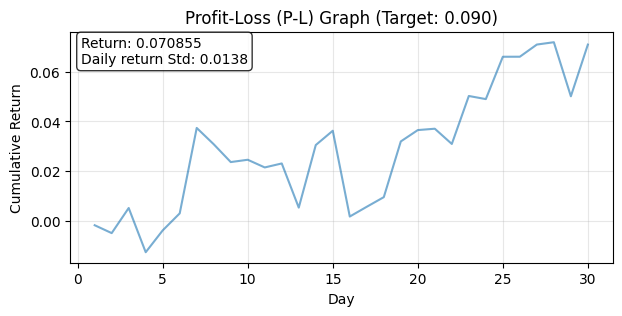

In [96]:
# Function to load the model, evaluate the trajectories using the model and plot the P-L plot for decision transformer
model_path = 'dt_model_target_0.090_scale_0.1.pth'
eval_dataset_path = 'data/real_stock_eval_31x50.pkl'
train_dataset_path = 'data/medium.pkl'
target_return = 0.09
scale = 0.1
K = 31
embed_dim = 128
n_layer = 3
n_head = 1
device = 'cuda'

def load_model(model_path, variant):
    device = variant['device']
    model = DecisionTransformer(
        state_dim=variant['state_dim'],
        act_dim=variant['act_dim'],
        max_length=variant['K'],
        max_ep_len=variant['max_ep_len'],
        hidden_size=variant['embed_dim'],
        n_layer=variant['n_layer'],
        n_head=variant['n_head'],
        n_inner=4*variant['embed_dim'],
        activation_function=variant.get('activation_function', 'relu'),
        n_positions=1024,
        resid_pdrop=variant.get('dropout', 0.1),
        attn_pdrop=variant.get('dropout', 0.1),
    ).to(device=device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def evaluate_episode_with_model(model, eval_traj, target_return, max_ep_len, scale, state_mean, state_std, device):
    '''evaluate the evaj_traj with the saved trained model, return the generated actions and the resulting returns'''
    
    # Switches the model to evaluation mode (e.g., turns off dropout, etc)
    model.eval()
    
    # Load and normalize the evaluation data
    original_states = eval_traj['observations'].astype(np.float32)
    original_rewards = eval_traj['rewards'].astype(np.float32)
    state_dim = original_states.shape[1]
    act_dim = eval_traj['actions'].shape[1]
    normalized_states = (original_states - state_mean.astype(np.float32)) / state_std.astype(np.float32)
    
    # Initialize first state and empty tensors
    states = torch.from_numpy(normalized_states[0]).to(device=device, dtype=torch.float32).reshape(1, state_dim)
    # Creates a zero-tensor with 0 rows
    actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
    rewards = torch.zeros(0, device=device, dtype=torch.float32)
    target_return_tensor = torch.tensor(target_return / scale, device=device, dtype=torch.float32).reshape(1, 1)
    timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
    
    # Record all actions and resulting portfolio returns.
    generated_actions = []
    portfolio_returns = []
    for t in range(len(original_states)):
        # Grow actions and rewards as we sweep through time
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device, dtype=torch.float32)], dim=0) # 0 dumy variable
        rewards = torch.cat([rewards, torch.zeros(1, device=device, dtype=torch.float32)])
        with torch.no_grad():
            # Get action from the loaded model
            action = model.get_action(
                states.to(dtype=torch.float32),
                actions.to(dtype=torch.float32),
                rewards.to(dtype=torch.float32),
                target_return_tensor.to(dtype=torch.float32),
                timesteps.to(dtype=torch.long),
            )
            action = project_portfolio_weights(action.unsqueeze(0)).squeeze(0)
            actions[-1] = action
            action_np = action.detach().cpu().numpy()
            generated_actions.append(action_np.copy())
        
        # Compute return if not last timestep
        if t < len(original_states) - 1:
            p_t = original_states[t]
            p_tp1 = original_states[t + 1]
            asset_returns = (p_tp1 - p_t) / p_t
            portfolio_return = np.dot(action_np, asset_returns)
            portfolio_returns.append(float(portfolio_return))
            rewards[-1] = torch.tensor(portfolio_return, device=device, dtype=torch.float32)
            # Update return-to-go and next state
            current_rtg = target_return_tensor[0, -1].item()
            scaled_reward = portfolio_return / scale
            pred_return = torch.tensor((1 + current_rtg) / (1 + scaled_reward) - 1, device=device, dtype=torch.float32)
            target_return_tensor = torch.cat([target_return_tensor, pred_return.reshape(1, 1)], dim=1)
            if t + 1 < len(original_states):
                next_state = torch.from_numpy(normalized_states[t + 1]).to(device=device, dtype=torch.float32).reshape(1, state_dim)
                states = torch.cat([states, next_state], dim=0)
                timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (t+1)], dim=1)
    return np.array(generated_actions), np.array(portfolio_returns)

def plot_profit_loss_curves(all_portfolio_returns, target_return):
    num_trajectories = len(all_portfolio_returns)
    final_returns = []
    plt.figure(figsize=(7, 3))
    # for ith value in all_portfolio_returns
    for i, portfolio_returns in enumerate(all_portfolio_returns):
        if len(portfolio_returns) > 0:
            cumulative_returns_dt = np.cumprod(1 + portfolio_returns) - 1
            final_return = np.prod(1 + portfolio_returns) - 1
            final_returns.append(final_return)
            days = range(1, len(cumulative_returns_dt) + 1)
            plt.plot(days, cumulative_returns_dt, alpha=0.6)
    plt.title(f"Profit-Loss (P-L) Graph (Target: {target_return:.3f})")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.grid(True, alpha=0.3)
    if final_returns:
        mean_return = np.mean(final_returns)
        std_return = np.std(final_returns)
        plt.text(0.02, 0.98, f'Return: {mean_return:.6f}\nDaily return Std: {portfolio_returns.std():.4f}', 
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    return final_returns, days, cumulative_returns_dt, portfolio_returns

if __name__ == "__main__":
    with open(train_dataset_path, 'rb') as f:
        train_trajectories = pickle.load(f)
    
    train_states = []
    for path in train_trajectories:
        train_states.append(path['observations'])
    states_concat = np.concatenate(train_states, axis=0)
    state_mean = np.mean(states_concat, axis=0)
    state_std = np.std(states_concat, axis=0) + 1e-6
    
    with open(eval_dataset_path, 'rb') as f:
        eval_trajectories = pickle.load(f)
    
    state_dim = states_concat.shape[1]
    act_dim = train_trajectories[0]['actions'].shape[1]
    max_ep_len = len(eval_trajectories[0]['observations'])
    
    variant = {
        'device': device,
        'state_dim': state_dim,
        'act_dim': act_dim,
        'max_ep_len': max_ep_len,
        'K': K,
        'embed_dim': embed_dim,
        'n_layer': n_layer,
        'n_head': n_head,
    }
    
    model = load_model(model_path, variant)
    
    all_portfolio_returns = []
    for i, traj in enumerate(eval_trajectories):
        try:
            generated_actions, portfolio_returns = evaluate_episode_with_model(
                model, traj, target_return, max_ep_len, scale, state_mean, state_std, device
            )
            all_portfolio_returns.append(portfolio_returns)
        except Exception as e:
            all_portfolio_returns.append(np.array([]))
    final_returns_08, days_08, cumulative_returns_dt_08, portfolio_returns_08 = plot_profit_loss_curves(all_portfolio_returns, target_return)
    
if len(portfolio_returns_08) > 1:
    daily_mean_return = np.mean(portfolio_returns_08)
    daily_std_return = np.std(portfolio_returns_08)
    sharpe_ratio = daily_mean_return / daily_std_return
    print(f"\nSharpe Ratio (daily, risk-free=0): {sharpe_ratio:.4f}")
else:
    print("Not enough data points to compute Sharpe Ratio.")



Sharpe Ratio (daily, risk-free=0): 0.1757


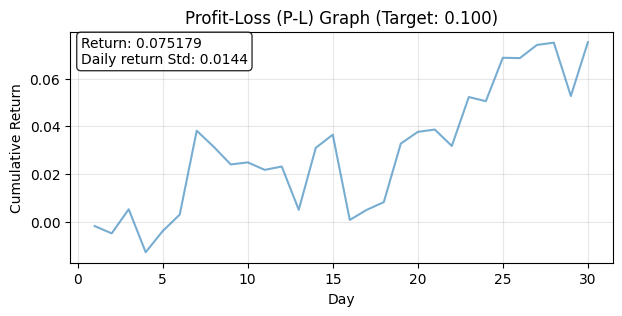

In [99]:
target_return = 0.10
all_portfolio_returns = []
for i, traj in enumerate(eval_trajectories):
    try:
        generated_actions, portfolio_returns = evaluate_episode_with_model(
            model, traj, target_return, max_ep_len, scale, state_mean, state_std, device
         )
        all_portfolio_returns.append(portfolio_returns)
    except Exception as e:
        all_portfolio_returns.append(np.array([]))
final_returns_10, days_10, cumulative_returns_dt_10, portfolio_returns_10 = plot_profit_loss_curves(all_portfolio_returns, target_return)
    
if len(portfolio_returns_10) > 1:
    daily_mean_return = np.mean(portfolio_returns_10)
    daily_std_return = np.std(portfolio_returns_10)
    sharpe_ratio = daily_mean_return / daily_std_return
    print(f"\nSharpe Ratio (daily, risk-free=0): {sharpe_ratio:.4f}")
else:
    print("Not enough data points to compute Sharpe Ratio.")


Sharpe Ratio (daily, risk-free=0): 0.1783


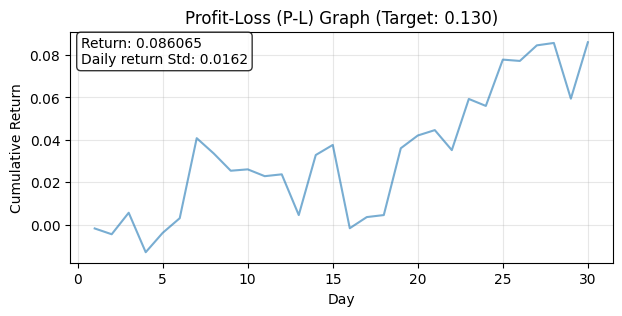

In [100]:
target_return = 0.13
all_portfolio_returns = []
for i, traj in enumerate(eval_trajectories):
    try:
        generated_actions, portfolio_returns = evaluate_episode_with_model(
            model, traj, target_return, max_ep_len, scale, state_mean, state_std, device
         )
        all_portfolio_returns.append(portfolio_returns)
    except Exception as e:
        all_portfolio_returns.append(np.array([]))
final_returns_13, days_13, cumulative_returns_dt_13, portfolio_returns_13 = plot_profit_loss_curves(all_portfolio_returns, target_return)
    
if len(portfolio_returns_13) > 1:
    daily_mean_return = np.mean(portfolio_returns_13)
    daily_std_return = np.std(portfolio_returns_13)
    sharpe_ratio = daily_mean_return / daily_std_return
    print(f"\nSharpe Ratio (daily, risk-free=0): {sharpe_ratio:.4f}")
else:
    print("Not enough data points to compute Sharpe Ratio.")


Sharpe Ratio (daily, risk-free=0): 0.1735


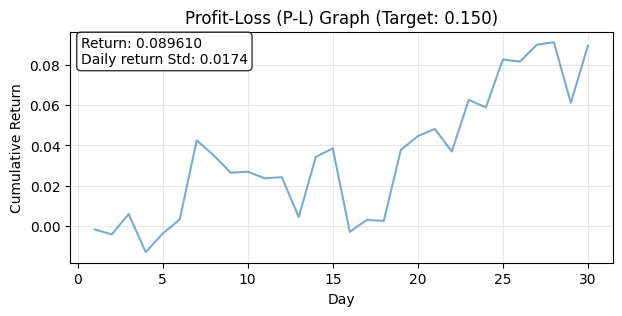

In [101]:
target_return = 0.15
all_portfolio_returns = []
for i, traj in enumerate(eval_trajectories):
    try:
        generated_actions, portfolio_returns = evaluate_episode_with_model(
            model, traj, target_return, max_ep_len, scale, state_mean, state_std, device
         )
        all_portfolio_returns.append(portfolio_returns)
    except Exception as e:
        all_portfolio_returns.append(np.array([]))
final_returns_15, days_15, cumulative_returns_dt_15, portfolio_returns_15 = plot_profit_loss_curves(all_portfolio_returns, target_return)

if len(portfolio_returns_15) > 1:
    daily_mean_return = np.mean(portfolio_returns_15)
    daily_std_return = np.std(portfolio_returns_15)
    sharpe_ratio = daily_mean_return / daily_std_return
    print(f"\nSharpe Ratio (daily, risk-free=0): {sharpe_ratio:.4f}")
else:
    print("Not enough data points to compute Sharpe Ratio.")

The return starts to decrease for targets above 1.7%

Sharpe Ratio (daily, risk-free=0): 0.1618


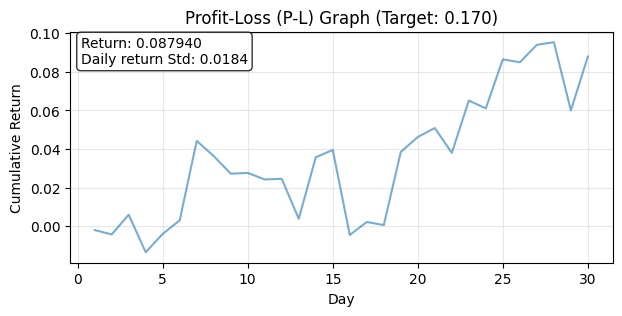

In [102]:
target_return = 0.17
all_portfolio_returns = []
for i, traj in enumerate(eval_trajectories):
    try:
        generated_actions, portfolio_returns = evaluate_episode_with_model(
            model, traj, target_return, max_ep_len, scale, state_mean, state_std, device
         )
        all_portfolio_returns.append(portfolio_returns)
    except Exception as e:
        all_portfolio_returns.append(np.array([]))
final_returns_17, days_17, cumulative_returns_dt_17, portfolio_returns_17 = plot_profit_loss_curves(all_portfolio_returns, target_return)

print("The return starts to decrease for targets above 1.7%")

if len(portfolio_returns_17) > 1:
    daily_mean_return = np.mean(portfolio_returns_17)
    daily_std_return = np.std(portfolio_returns_17)
    sharpe_ratio = daily_mean_return / daily_std_return
    print(f"\nSharpe Ratio (daily, risk-free=0): {sharpe_ratio:.4f}")
else:
    print("Not enough data points to compute Sharpe Ratio.")

Therefore we see we have the highest Sharpe ratio (0.1783) when the target is set as 0.13.

# Analysis of Models' Performance on Evaluation Set

Here we plot the performance of all three models for comparison.

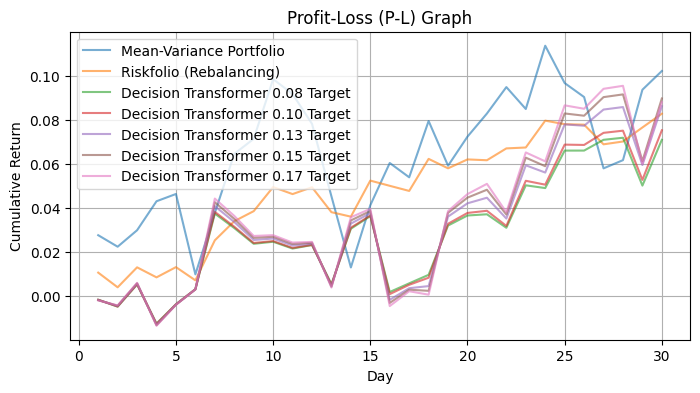

In [103]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_returns_mvp) + 1), cumulative_returns_mvp, alpha=0.6, label = "Mean-Variance Portfolio")
plt.plot(range(1, len(cumulative_returns_mvp) + 1), cumulative_return_risk[1:], alpha=0.6, label = "Riskfolio (Rebalancing)")
plt.plot(days_08, cumulative_returns_dt_08, alpha=0.6, label = "Decision Transformer 0.08 Target")
plt.plot(days_10, cumulative_returns_dt_10, alpha=0.6, label = "Decision Transformer 0.10 Target")
plt.plot(days_13, cumulative_returns_dt_13, alpha=0.6, label = "Decision Transformer 0.13 Target")
plt.plot(days_15, cumulative_returns_dt_15, alpha=0.6, label = "Decision Transformer 0.15 Target")
plt.plot(days_17, cumulative_returns_dt_17, alpha=0.6, label = "Decision Transformer 0.17 Target")
plt.legend()
plt.title("Profit-Loss (P-L) Graph")
plt.xlabel("Day")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

## Summary of Returns and Volatility

| Model                     | Total Return | Daily Return Std |
|---------------------------|--------------|------------------|
| Mean-Variance Portfolio   | 10.21%       | 1.95%            |
| Riskfolio (Rebalancing)   | 8.27%        | 0.71%            |
| Decision Transformer (DT) | 8.60%        | 1.62%            |

---

## Performance Analysis

### 1. **Overall Return**
- The **Mean-Variance Portfolio** clearly outperformed both the Decision Transformer (DT) and the Riskfolio approach in terms of cumulative return, achieving a final cumulative return of **10.21%** over the 30-day evaluation period.
- Both **Decision Transformer** (**8.19%**) and **Riskfolio** (**8.27%**) produced similar final cumulative returns, which are moderately lower than the Mean-Variance Portfolio.

### 2. **Volatility (Risk)**
- **Riskfolio** exhibited the lowest volatility (**0.71% daily std**), implying a very stable and consistent growth trajectory. This aligns well with its goal of maximizing the Sharpe ratio, thus prioritizing stable and consistent returns.
- **Decision Transformer** demonstrated moderate volatility (**1.45% daily std**), which was higher than Riskfolio but significantly lower than the Mean-Variance Portfolio.
- The **Mean-Variance Portfolio**, despite having the highest returns, also experienced the highest daily volatility (**1.95% daily std**). This indicates it followed a more aggressive investment strategy, which although profitable, involved greater risk and potential fluctuations in returns.

### 3. **Return-Risk Trade-Off**
- The higher cumulative return of the **Mean-Variance Portfolio** comes at the cost of higher volatility, making it suitable for investors who are more risk-tolerant and seeking greater returns over a short-term horizon.
- The **Riskfolio approach**, while achieving slightly lower returns compared to the Mean-Variance Portfolio, offered considerably more stability, appealing to investors with a conservative risk profile.
- The **Decision Transformer** positions itself between these two extremes, capturing competitive returns with moderate volatility. This demonstrates that the Decision Transformer successfully learned a balanced strategy, albeit slightly less stable than Riskfolio's Sharpe-ratio maximization.

### 4. **Trajectory Insights from Plot**
- The plot clearly illustrates the above observations:
  - The **Mean-Variance Portfolio** shows pronounced fluctuations, especially notable peaks around days 10 and 17, underscoring its aggressive investment style.
  - **Riskfolio** maintains a steadily upward-sloping trajectory, reflecting its conservative approach, with only modest dips.
  - **Decision Transformer**, initially slower to generate returns, catches up toward the latter half of the evaluation period, demonstrating its adaptability and gradual learning effectiveness.

---

## Conclusion
The Mean-Variance Portfolio achieves the highest return but at the expense of increased volatility. Riskfolio provides a stable return profile, ideal for risk-averse strategies. The Decision Transformer achieves a desirable balance between these two models, combining moderate returns with reasonable volatility, demonstrating its effectiveness in realistic financial environments.

# Training Trajectories Visualization

First trajectory: {'observations': array([[210.14, 391.16, 285.88],
       [211.21, 394.04, 292.03],
       [212.5 , 395.26, 282.16],
       [213.32, 425.4 , 280.52],
       [205.35, 435.28, 287.21],
       [198.89, 436.17, 280.26],
       [198.51, 433.31, 275.35],
       [196.25, 433.35, 276.22],
       [197.49, 438.17, 284.82],
       [198.53, 438.73, 298.26],
       [210.79, 449.26, 318.38],
       [212.93, 449.14, 334.07],
       [212.33, 452.94, 347.68],
       [211.45, 453.13, 342.82],
       [211.26, 454.27, 349.98],
       [208.78, 458.87, 342.09],
       [206.86, 458.17, 343.82],
       [202.09, 452.57, 334.62],
       [201.36, 454.86, 341.04],
       [195.27, 450.18, 339.34],
       [200.21, 460.69, 362.89],
       [200.42, 457.36, 356.9 ],
       [199.95, 458.68, 358.43],
       [200.85, 460.36, 346.46],
       [201.7 , 461.97, 342.69],
       [203.27, 462.97, 344.27],
       [202.82, 463.87, 332.05],
       [200.63, 467.68, 284.7 ],
       [203.92, 470.38, 295.14],
       [

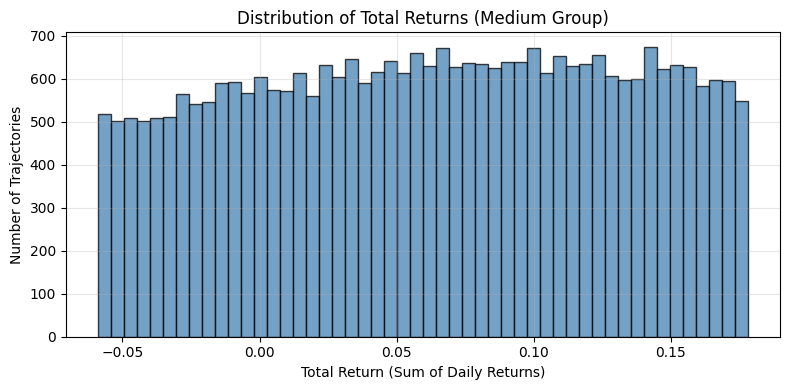

In [87]:
# Path to the saved pickle file
pkl_path = 'data/medium.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as f:
    trajectories = pickle.load(f)

# Inspect the first trajectory to check the structure
print("First trajectory:", trajectories[0])

# Optionally, inspect the keys of the first trajectory's dictionary
print("Keys of the first trajectory:", trajectories[0].keys())

# Check the shape of observations, actions, rewards, and dones in the first trajectory
print("Observations shape:", trajectories[0]['observations'].shape)
print("Actions shape:", trajectories[0]['actions'].shape)
print("Rewards shape:", trajectories[0]['rewards'].shape)
print("Dones shape:", trajectories[0]['dones'].shape)

# Print the number of trajectories
print("Number of trajectories in file:", len(trajectories))


states, traj_lens, returns = [], [], []
for path in trajectories:
    states.append(path['observations'])
    traj_lens.append(len(path['observations']))
    returns.append(np.prod(1 + path['rewards'][1:]) - 1)
traj_lens, returns = np.array(traj_lens), np.array(returns)


print(len(traj_lens))

print(f'Average return: {np.mean(returns):.2f}, std: {np.std(returns):.2f}')
print(f'Max return: {np.max(returns):.2f}, min: {np.min(returns):.2f}')

print("Training set return stats:")
print(f"Mean: {np.mean(returns):.4f}, Std: {np.std(returns):.4f}, Max: {np.max(returns):.4f}, Min: {np.min(returns):.4f}")
for thresh in [0.05, 0.06, 0.07]:
    print(f"Trajectories >= {thresh}: {np.sum(returns >= thresh)}")

print(f"Trajectories with return between 0.05 and 0.051: {np.sum((returns >= 0.049) & (returns < 0.051))}")

# === Plot histogram of returns ===
plt.figure(figsize=(8, 4))
plt.hist(returns, bins=50, alpha=0.75, color='steelblue', edgecolor='black')
plt.title("Distribution of Total Returns (Medium Group)")
plt.xlabel("Total Return (Sum of Daily Returns)")
plt.ylabel("Number of Trajectories")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()